# House Prices - Feature Engineering and Model Optimization
This project develops and deepens the model created in the previous study.
It is based on a reused preprocessing pipeline and the XGBoost model. The main focus is on feature engineering, selection of the most significant parameters, clustering, and encoding strategies, which are aimed at improving the model's performance. 

## Data loading and preparation
- I import all the necessary libraries for data analysis, visualization, preprocessing, modeling, and evaluation. Then I load the training dataset, which includes the target variable "SalePrice", and the test dataset

- The "Id" column serves as an index for matching predictions with the original data. I select the target variable ("SalePrice") and separate it from the input features. Next, I automatically divide the features into numerical and categorical ones depending on their data type

- I also define an helper function to evaluate models using cross-validation and calculate the mean MAE and its standard deviation

- As the main prediction model, I use a tuned XGBoost regressor, which serves as a baseline model combining preprocessing and XGBoost. All further improvements will be compared to this baseline model

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

train_data = pd.read_csv("C:\\Users\\lb_20\\Downloads\\train.csv", index_col = "Id")
test_data = pd.read_csv("C:\\Users\\lb_20\\Downloads\\test.csv", index_col = "Id")

y = train_data["SalePrice"]
X = train_data.drop(columns = ["SalePrice"])
X_test = test_data.copy()

categorical_cols = []
numerical_cols = []
for col in X.columns:
    if X[col].dtype == "object":
       categorical_cols.append(col)
    else:
        numerical_cols.append(col)

numerical_transformer = SimpleImputer(strategy = "median")

categorical_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy = "most_frequent")),
                                            ("onehot", OneHotEncoder(handle_unknown = "ignore"))])

preprocessor = ColumnTransformer(transformers = [("num", numerical_transformer, numerical_cols),
                                                 ("cat", categorical_transformer, categorical_cols)])

def cross_val_mae(pipeline, X, y, cv = 5):
    scores = cross_val_score(pipeline, X, y,
                             cv = cv,
                             scoring = "neg_mean_absolute_error",
                             n_jobs = -1)
    mae = -scores
    return mae.mean(), mae.std()

xgb = XGBRegressor(objective = "reg:squarederror",
                   random_state = 0,
                   n_jobs = 1,
                   n_estimators = 2000,
                   learning_rate = 0.03,
                   max_depth = 3,
                   subsample = 0.8,
                   colsample_bytree = 0.7,
                   reg_lambda = 2.0,
                   reg_alpha = 0.1)
baseline_pipeline = Pipeline(steps = [("preprocess", preprocessor), ("model", xgb)])

## Baseline evaluation
I evaluate the baseline model using cross-validation and log the results

In [5]:
baseline_mae, baseline_std = cross_val_mae(baseline_pipeline, X, y)
print(f"Baseline CV MAE: {baseline_mae:.2f} ± {baseline_std:.2f}")

Baseline CV MAE: 14923.86 ± 969.54


In [6]:
results = []
def log_result(name, mae_mean, mae_std, notes = ""):
    results.append({"version": name,
                    "mae_mean": mae_mean,
                    "mae_std": mae_std,
                    "notes": notes})

In [7]:
baseline_mae, baseline_std = cross_val_mae(baseline_pipeline, X, y)
log_result(name = "Baseline (tuned XGB + OHE)",
           mae_mean = baseline_mae,
           mae_std = baseline_std,
           notes = "Imputer + OneHot, no feature engineering")

## Preprocessing for Mutual Information
I create a validation split that is used only for feature selection and exploratory analysis  
For Mutual Information, categorical features are ordinal-encoded

In [9]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

numerical_transformer_MI = SimpleImputer(strategy = "median")
categorical_transformer_MI = Pipeline(steps = [("imputer", SimpleImputer(strategy = "most_frequent")),
                                               ("ordinal", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1))])
MI_preprocessor = ColumnTransformer(transformers = [("num", numerical_transformer_MI, numerical_cols),
                                                    ("cat", categorical_transformer_MI, categorical_cols)])

train_X_MI = MI_preprocessor.fit_transform(train_X)

## Mutual Information scores
I compute Mutual Information scores to measure non-linear relationships between features and the target

In [11]:
MI_scores = mutual_info_regression(train_X_MI, train_y, random_state = 0)
feature_names = numerical_cols + categorical_cols
MI = pd.Series(MI_scores, index = feature_names).sort_values(ascending = False)

MI.head(20)

OverallQual     0.540271
Neighborhood    0.511625
GrLivArea       0.486592
TotalBsmtSF     0.395558
GarageCars      0.393728
GarageArea      0.383772
YearBuilt       0.356860
ExterQual       0.334020
1stFlrSF        0.328802
BsmtQual        0.327615
KitchenQual     0.312089
GarageYrBlt     0.310941
MSSubClass      0.267741
FullBath        0.264252
YearRemodAdd    0.248107
LotFrontage     0.229710
GarageFinish    0.229484
2ndFlrSF        0.223003
Foundation      0.219842
TotRmsAbvGrd    0.208770
dtype: float64

## Top features by Mutual Information
I visualize the top features ranked by Mutual Information score

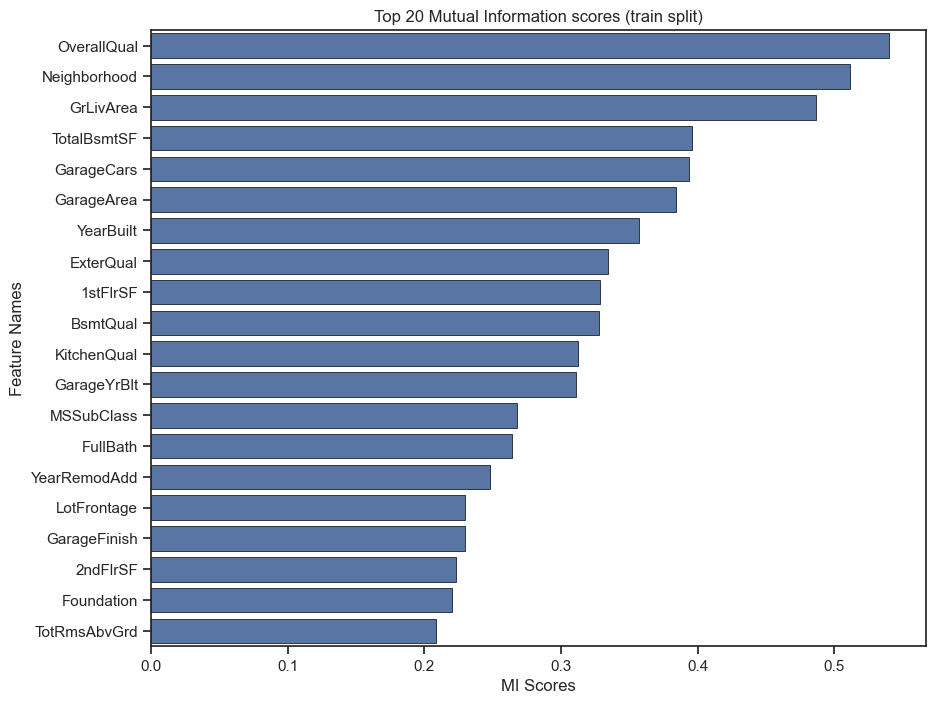

In [13]:
top20 = MI.head(20)
sns.set_theme(style = "ticks")
plt.figure(figsize = (10, 8))

sns.barplot(x = top20.values, y = top20.index, 
            edgecolor = "black", 
            linewidth = 0.5)
plt.title("Top 20 Mutual Information scores (train split)")
plt.xlabel("MI Scores")
plt.ylabel("Feature Names")
plt.show()

## Exploratory analysis
I visually inspect relationships between important features and "SalePrice" to better understand their behavior

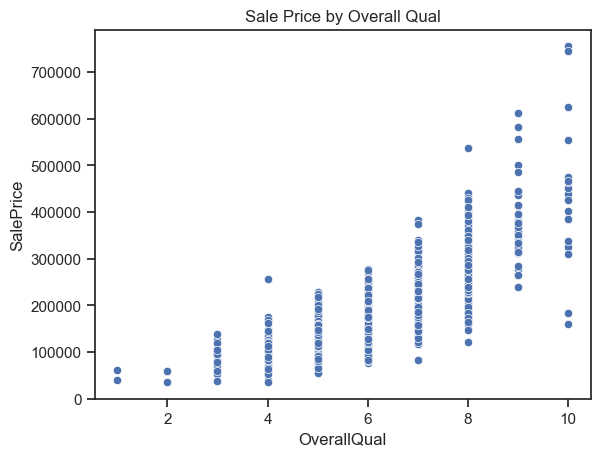

In [15]:
sns.scatterplot(x = "OverallQual", y = "SalePrice", data = train_data)
plt.title("Sale Price by Overall Qual")
plt.show()

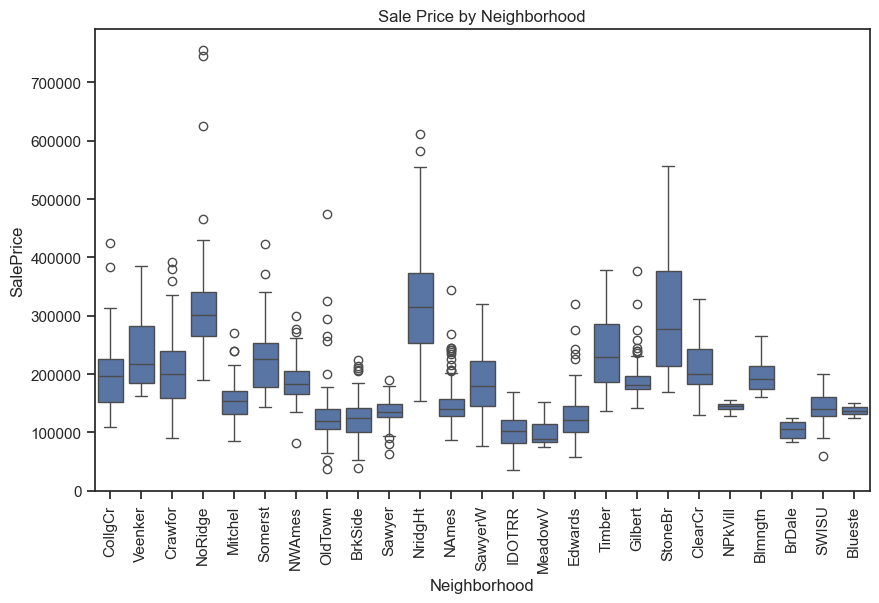

In [16]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = "Neighborhood", y = "SalePrice", data = train_data)
plt.xticks(rotation = 90)
plt.title("Sale Price by Neighborhood")
plt.show()

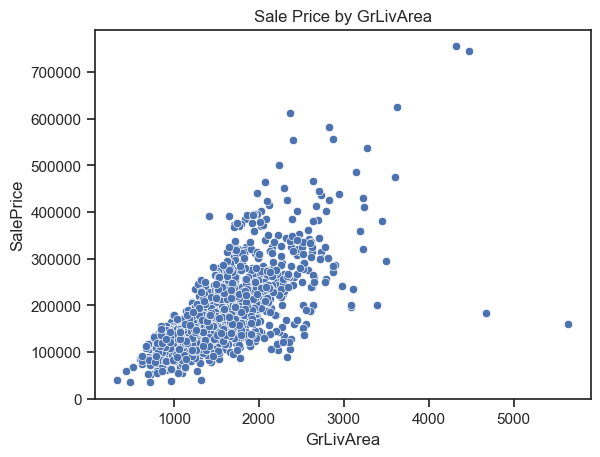

In [17]:
sns.scatterplot(x = "GrLivArea", y = "SalePrice", data = train_data)
plt.title("Sale Price by GrLivArea")
plt.show()

## Feature engineering
I create additional features to better represent:
- total living space
- bathrooms
- house age and renovation age
- quality–size interaction
- presence of garage and basement

In [19]:
train_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [20]:
def add_features(df):
    df = df.copy()
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["PorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
    df["TotalBath"] = (df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"])
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["IsRemod"] = (df["YearRemodAdd"] > df["YearBuilt"]).astype(int)
    df["Qual_x_Area"] = df["OverallQual"] * df["GrLivArea"]
    df["HasGarage"] = (df["GarageArea"] > 0).astype(int)
    df["HasBasement"] = (df["TotalBsmtSF"] > 0).astype(int)
    return df

## Feature engineering evaluation
I evaluate the model after adding engineered features and compare the performance to the baseline

In [22]:
X_features = add_features(X)
categorical_cols_features = [c for c in X_features.columns if X_features[c].dtype == "object"]
numerical_cols_features = [c for c in X_features.columns if X_features[c].dtype != "object"]

preprocessor_features = ColumnTransformer(transformers = [("num", numerical_transformer, numerical_cols_features),
                                                          ("cat", categorical_transformer, categorical_cols_features)])

features_pipeline = Pipeline(steps = [("preprocess", preprocessor_features), ("model", xgb)])
features_mae, features_std = cross_val_mae(features_pipeline, X_features, y)
print(f"Creating Features CV MAE: {features_mae:.2f} ± {features_std:.2f}")

Creating Features CV MAE: 14747.11 ± 1042.11


In [23]:
set(X_features.columns) - set(X.columns)

{'HasBasement',
 'HasGarage',
 'HouseAge',
 'IsRemod',
 'PorchSF',
 'Qual_x_Area',
 'RemodAge',
 'TotalBath',
 'TotalSF'}

In [24]:
log_result(name = "Creating Features",
           mae_mean = features_mae,
           mae_std = features_std,
           notes = "Added TotalSF, PorchSF, TotalBath, HouseAge, RemodAge, Qual_x_Area, flags(IsRemod, HasGarage, HasBasement)")

## KMeans clustering
I apply KMeans clustering to group houses with similar size, quality,age, and amenities. The resulting cluster is used as a new categorical feature.

In [26]:
cluster_cols = ["TotalSF", "GrLivArea", "GarageArea", "HouseAge", "TotalBath", "PorchSF"]
kmeans_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy = "median")),
                                    ("scaler", StandardScaler()),
                                    ("kmeans", KMeans(n_clusters = 10, random_state = 0, n_init = 10))])

kmeans_pipeline.fit(X_features[cluster_cols])

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

## Fit clustering pipeline
Clustering is performed using standardized numerical features  
Each house is assigned to a cluster, which is added as a categorical feature  
I evaluate the model with the additional cluster feature to measure its impact on prediction quality

In [28]:
X_features_cluster = X_features.copy()
X_features_cluster["Cluster"] = kmeans_pipeline.predict(X_features_cluster[cluster_cols]).astype(str)

categorical_cols_cluster = [c for c in X_features_cluster.columns if X_features_cluster[c].dtype == "object"]
numerical_cols_cluster   = [c for c in X_features_cluster.columns if X_features_cluster[c].dtype != "object"]

preprocessor_cluster = ColumnTransformer(transformers = [("num", numerical_transformer, numerical_cols_cluster),
                                                         ("cat", categorical_transformer, categorical_cols_cluster)])

cluster_pipeline = Pipeline(steps = [("preprocess", preprocessor_cluster), ("model", xgb)])

cluster_mae, cluster_std = cross_val_mae(cluster_pipeline, X_features_cluster, y)
print(f"FE + Clusters CV MAE: {cluster_mae:.2f} ± {cluster_std:.2f}")

FE + Clusters CV MAE: 14601.90 ± 1002.68


## Cluster visualization
I visualize how clusters relate to SalePrice and key numerical features

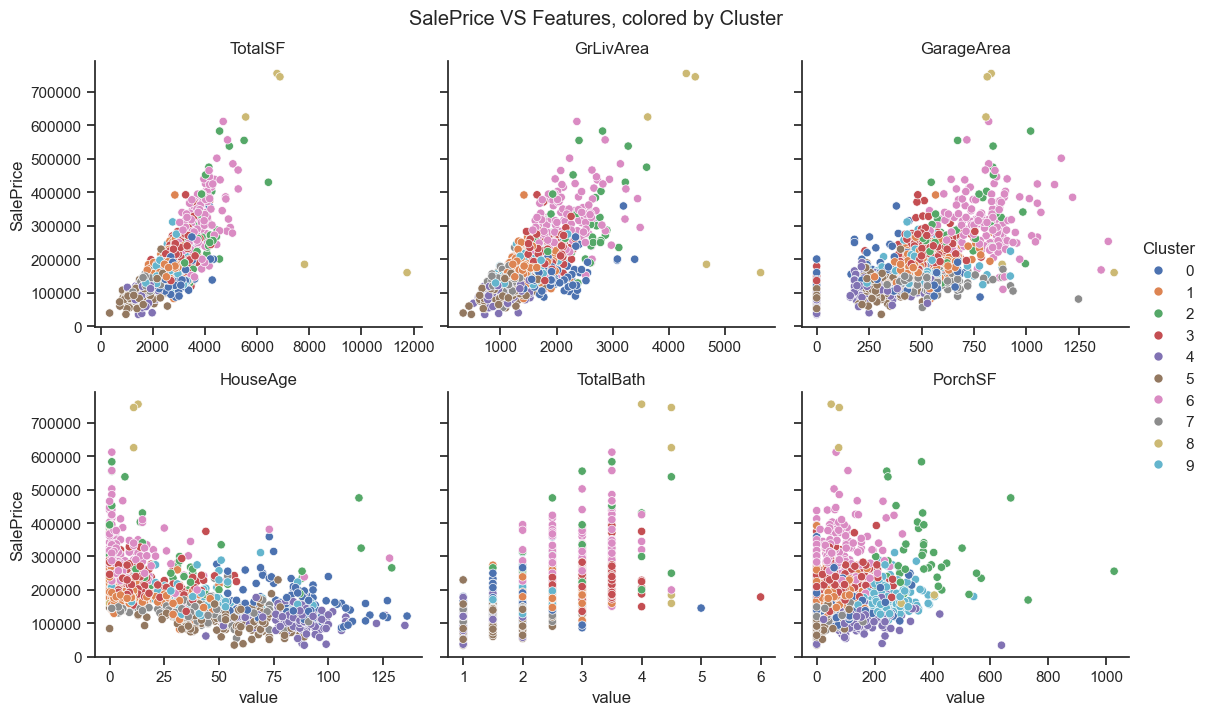

In [30]:
Xy = X_features_cluster.copy()
Xy["SalePrice"] = y
Xy["Cluster"] = Xy["Cluster"].astype("category")
long_df = Xy.melt(id_vars = ["SalePrice", "Cluster"],
                  value_vars = cluster_cols,
                  var_name = "feature",
                  value_name = "value")
gr = sns.relplot(data = long_df,
                 x = "value", y = "SalePrice",
                 hue = "Cluster",
                 col = "feature",
                 col_wrap = 3,
                 height = 3.5,
                 aspect = 1.1,
                 facet_kws = {"sharex": False})
gr.set_titles("{col_name}")
gr.fig.suptitle("SalePrice VS Features, colored by Cluster", y = 1.02)
plt.show()

## SalePrice distribution by cluster
Boxplots show how SalePrice differs across clusters  
This helps interpret what each cluster represents

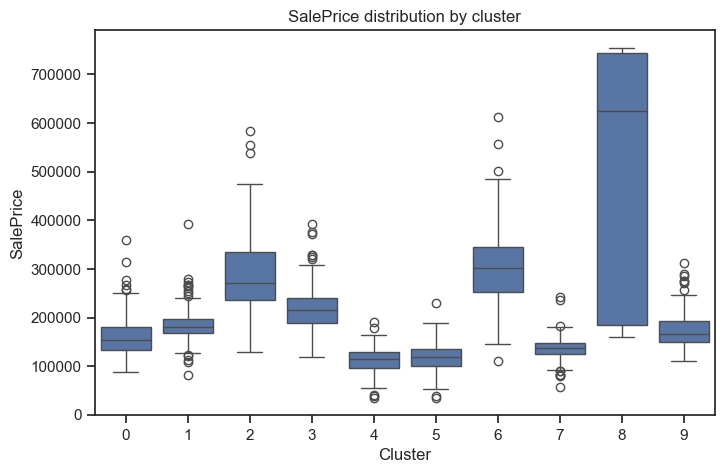

In [32]:
tmp = X_features_cluster.copy()
tmp["SalePrice"] = y

plt.figure(figsize=(8, 5))
sns.boxplot(data = tmp, x = "Cluster", y = "SalePrice", order = range(10))
plt.title("SalePrice distribution by cluster")
plt.show()

## Cluster profiles
I compute average feature values per cluster to better understand their characteristics

In [34]:
cluster_profile = (X_features_cluster.groupby("Cluster")[cluster_cols].mean().round(1))
cluster_profile

,TotalSF,GrLivArea,GarageArea,HouseAge,TotalBath,PorchSF
Cluster,,,,,,
0,2894.6,1958.6,360.3,80.4,2.1,102.9
1,2544.4,1473.9,503.6,12.2,2.4,46.3
2,3890.5,2412.9,685.8,33.1,3.2,376.7
3,2959.1,1776.3,520.5,16.5,3.1,81.0
4,1897.8,1150.8,249.5,81.2,1.3,155.9
5,1836.3,1060.3,245.1,50.7,1.5,16.1
6,3708.4,2145.6,798.5,9.5,2.8,77.6
7,1975.7,1088.8,535.1,40.6,1.8,15.1
8,7751.0,4547.4,950.8,7.0,4.4,180.4


## Cluster sizes
I check how many samples belong to each cluster

In [36]:
cluster_sizes = X_features_cluster["Cluster"].value_counts().sort_index()
cluster_sizes

Cluster
0    106
1    275
2     44
3    193
4    136
5    240
6    164
7    179
8      5
9    118
Name: count, dtype: int64

In [37]:
log_result(name = "KMeans Clusters",
           mae_mean = cluster_mae,
           mae_std = cluster_std,
           notes = "KMeans clusters by size, quality, age, and conveniences added as categorical characteristics")

## Hybrid categorical encoding
I am experimenting with a hybrid encoding strategy:
- Categorical features with low cardinality encode using One-Hot Encoding
- Categorical features with high cardinality encode using Target Encoding

In [39]:
X_model = X_features_cluster
categorical_cols_model = [c for c in X_model.columns if X_model[c].dtype == "object"]
numerical_cols_model   = [c for c in X_model.columns if X_model[c].dtype != "object"]
card_threshold = 10
cat_nunique = X_model[categorical_cols_model].nunique().sort_values(ascending=False)

high_card_cols = cat_nunique[cat_nunique > card_threshold].index.tolist()
low_card_cols  = cat_nunique[cat_nunique <= card_threshold].index.tolist()

print("High-cardinality:", high_card_cols[:10], "..." if len(high_card_cols) > 10 else "")
print("The number of low-cardinality columns:", len(low_card_cols))
print("The number of high-cardinality columns:", len(high_card_cols))

High-cardinality: ['Neighborhood', 'Exterior2nd', 'Exterior1st'] 
The number of low-cardinality columns: 41
The number of high-cardinality columns: 3


## Hybrid encoding evaluation
I evaluate whether hybrid encoding improves performance compared to pure One-Hot Encoding

In [41]:
num_transformer = SimpleImputer(strategy = "median")

cat_transformer_ohe = Pipeline(steps = [("imputer", SimpleImputer(strategy = "most_frequent")),
                                        ("onehot", OneHotEncoder(handle_unknown = "ignore"))])

cat_transformer_te = Pipeline(steps = [("imputer", SimpleImputer(strategy = "most_frequent")),
                                       ("te", TargetEncoder(smoothing = 10))])

preprocessor_hybrid = ColumnTransformer(transformers = [("num", num_transformer, numerical_cols_model),
                                                        ("cat_ohe", cat_transformer_ohe, low_card_cols),
                                                        ("cat_te", cat_transformer_te, high_card_cols)])

hybrid_pipeline = Pipeline(steps = [("preprocess", preprocessor_hybrid), ("model", xgb)])

hybrid_mae, hybrid_std = cross_val_mae(hybrid_pipeline, X_model, y)
print(f"Hybrid (OHE + TE) CV MAE: {hybrid_mae:.2f} ± {hybrid_std:.2f}")

Hybrid (OHE + TE) CV MAE: 14960.33 ± 1215.58


In [42]:
log_result(name = "Hybrid Encoding (OHE low + TE high)",
           mae_mean = hybrid_mae,
           mae_std = hybrid_std,
           notes = f"Сard threshold={card_threshold}; TE cols={len(high_card_cols)}; OHE cols={len(low_card_cols)}")

## Model comparison
I compare all model variants using cross-validated MAE to select the best-performing approach

In [44]:
results_df = pd.DataFrame(results)

results_df = results_df.sort_values(["mae_mean", "mae_std"]).reset_index(drop=True)

results_df["mae_mean"] = results_df["mae_mean"].round(2)
results_df["mae_std"]  = results_df["mae_std"].round(2)

results_df

,version,mae_mean,mae_std,notes
0,KMeans Clusters,14601.90,1002.68,"KMeans clusters by size, quality, age, and con..."
1,Creating Features,14747.11,1042.11,"Added TotalSF, PorchSF, TotalBath, HouseAge, R..."
2,Baseline (tuned XGB + OHE),14923.86,969.54,"Imputer + OneHot, no feature engineering"
3,Hybrid Encoding (OHE low + TE high),14960.33,1215.58,Сard threshold=10; TE cols=3; OHE cols=41


## Train final model and Generate predictions
I train the best-performing pipeline on the full training dataset and apply the final model to the test dataset to generate predictions

In [46]:
final_pipeline = cluster_pipeline   
final_pipeline.fit(X_features_cluster, y)

X_test_fe = add_features(X_test)

X_test_fe = X_test_fe.copy()
X_test_fe["Cluster"] = kmeans_pipeline.predict(X_test_fe[cluster_cols]).astype(str)

test_preds = final_pipeline.predict(X_test_fe)

res = pd.DataFrame({"Id": X_test_fe.index, "SalePrice": test_preds})
res

,Id,SalePrice
0,1461,124099.687500
1,1462,162922.359375
2,1463,187447.921875
3,1464,196054.140625
4,1465,185474.484375
...,...,...
1454,2915,79844.765625
1455,2916,78131.914062
1456,2917,173857.625000
1457,2918,122337.906250
